# Discrete form

Finding the solution to the weak form {eq}`1drod_weak_final` derived in the [previous section](./chapter1-2_Weak_form_of_the_problem.md) is an infinite-dimensional problem, $u$ is unknown at every point $x$ in the domain and we also have an infinite number of possible weight functions $w$. In this section we will discretize the weak form such that it can be solved with a computer. With the aim to go from a continuous problem to a discrete problem, we approximate the solution by reducing the solution space to a finite number of unknowns and at the same time restricting the number of equation to a finite set.

```{figure} .././images/Chapter1/1_4_1.png
---
height: 200px
name: 1_4_1
---
Strong form to discrete form
```

## Shape functions

This is done by assuming a certain shape for $u(x)$ and restricting the set of functions $w(x)$ to all functions of that same shape.

Let's introduce a finite set of **shape functions** (or interpolation functions) $N_i(x)$ with $i\in[0,n-1]$, $n$ being the number of degrees of freedom (DOFs), and say that our approximate solution $u^h(x)$ is a linear combination of these shape functions:

$$ 
u^h(x) = \sum_{i=0}^{n-1}N_i(x)u_i 
$$ (interpolation)

where $u_i$ is the coefficient with which $N_i$ is multiplied. Note that $u_i$ is not a function of $x$, just a coefficient defined at each DOF. 

In the Finite Element method, once we have the weak form at the continuous level, we define a *discretization* of the domain, that is a mesh with nodes and elements, see Figure {numref}`1_4_2`

```{figure} .././images/Chapter1/1_4_2.png
---
height: 200px
name: 1_4_2
---
Triangulation of a 2D domain (left) and discretization of a 1D domain (right).
```
This mesh is used to define the shape functions with certain peculiarities:
- Every shape function $N_i$ belongs to a node with coordinates $x_i$.
- The shape function is equal to 1 at its own node and equal to zero at all other nodes.
- The shape function $N_i$ only takes values different from zero at the set of elements attached at to the $i$-th node, $S_i$.
- The shape function $N_i$ is defined by element-wise functions (typically polynomials)

$$
N_i(x) = \left\{ \begin{array}{cl} 
p(x), & x\in\Omega_k\ ∀ k\in S_i\\
1, & x=x_i \\ 
0, & \text{otherwise}
\end{array} \right. 
$$ (shape_function)

```{figure} .././images/Chapter1/1_4_3.png
---
height: 200px
name: 1_4_3
---
Interpolation of a function $u$ using piece-wise linear polynomials (left), approximated solution arround node $i$ (top-right) and shape functions for nodes $i-1$, $i$ and $i+1$ (bottom-right).
```

Note that the definition of the shape functions as in {eq}`shape_function` has a useful property: the coefficent $u_i$ is equal to the solution at node $i$: $u^h(x_i) = u_i$. 

By solving for $u^h$ instead of for $u$ our solution space is no longer infinitely dimensional, but has become $n$-dimensional. If we know the $u_i$ values for all $i$'s from 0 to $n-1$, using the interpolation defined in {eq}`interpolation`, we know $u^h$ for every $x$ in our domain. We are making an approximation here, it may be impossible to reconstruct the true solution $u(x)$ exactly with the simple shape functions $N_i(x)$, but it can be shown that if we increase the number of nodes, the true $u(x)$ will be approximated with increased accuracy. 

The following widget illustrates this concept.

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go

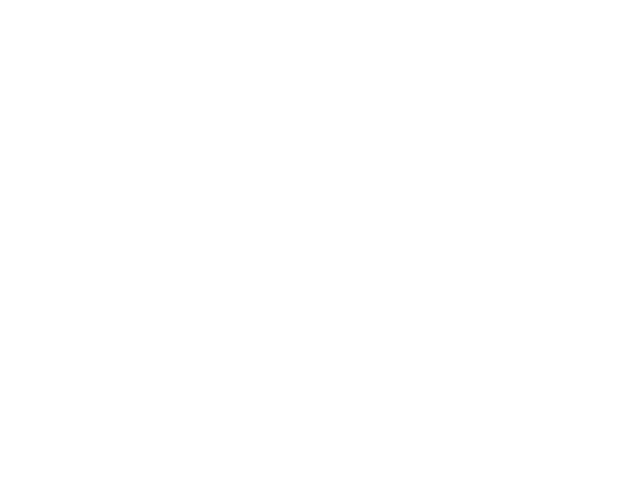

In [2]:
plt.figure()
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2})

def shape_functions(total_length, num_nodes, node_x):
    l = total_length / (num_nodes - 1)

    if node_x == 0:
        x = np.array([node_x, node_x + l])
        y = np.array([1.0, 0.0])
    elif node_x == total_length:
        x = np.array([node_x - l, node_x])
        y = np.array([0.0, 1.0])
    else:
        x = np.array([node_x - l, node_x, node_x + l])
        y = np.array([0.0, 1.0, 0.0])

    return x, y

def shape_functions_for_plot(num_nodes, beam_length = 15):

    x_positions = np.linspace(0, beam_length, num_nodes)

    data = {}

    for node_num, x_coords in enumerate(x_positions):

        x, y = shape_functions(beam_length, num_nodes, x_coords)
        data[node_num + 1] = {'x': x, 'y': y}

    return data

In [3]:
def linear_lagrange_shape_function(x, nodes_x_values, nodes_displacements):
    """
    Compute the linear Lagrange shape function for a given x.
    Args:
        x (float): The x-coordinate.
        x0 (float): Left node position.
        x1 (float): Right node position.
    Returns:
        float: The shape function value.
    """

    ratio = (x - nodes_x_values[0]) / (nodes_x_values[1] - nodes_x_values[0])

    return (1 - ratio) * nodes_displacements[0] + ratio * nodes_displacements[1]

def function(x):
    """
    Define the function to be plotted.
    Args:
        x (numpy.ndarray): Input values.
    Returns:
        numpy.ndarray: Corresponding function values.
    """
    return np.sin(x) * 0.14*x

def shape_functions_applied(num_elements):
    """
    Plot linear Lagrange shape functions on a beam.
    Args:
        num_elements (int): Number of elements (segments).
    """

    beam_length = 15

    num_nodes = num_elements + 1
    x_at_nodes = np.linspace(0, beam_length, num_nodes)

    y_at_nodes = function(x_at_nodes)

    x_data = np.linspace(0, beam_length, 1000)

    # Use NumPy to compute y_vals efficiently
    y_vals = np.zeros_like(x_data)

    for element_number in range(num_elements):
        mask = (x_at_nodes[element_number] <= x_data) & (x_data <= x_at_nodes[element_number + 1])
        y_vals[mask] = linear_lagrange_shape_function(x_data[mask], x_at_nodes[element_number:element_number + 2], y_at_nodes[element_number:element_number + 2])

    return x_data, function(x_data), y_vals


In [4]:
# Colors
grey = '#eeeeee'  # light grey fill

# Prepare all the graphs that are to be plotted
range_elements = np.concatenate((np.arange(1, 7, 1), np.arange(7, 35, 4), np.arange(35, 55, 8)))

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("Shape functions", "Exact and approximated solution"))

base_traces_left = 2  # Number of traces in the left plot that are always visible
base_traces_right = 0  # Number of traces in the right plot that are always visible

# Add traces to the subplots
x_data, y_data, y_vals = shape_functions_applied(10)

# Add left plot traces (Cumulative Influx and Cumulative Outflux)
fig.add_trace(
    go.Scatter(
        visible=True,  # Show for the first value of a
        x=x_data,
        y=y_data,
        # line=dict(color='#6a8ba4'),
        mode='lines',
        name='Exact solution'
    ),
    row=1,
    col=2
)


# Add traces to the subplots
for a in range_elements:

    x_data, y_data, y_vals = shape_functions_applied(a)

    fig.add_trace(
        go.Scatter(
            visible = True if a == range_elements[0] else False,  # Show for the first value of a
            x=x_data,
            y=y_vals,
            # line=dict(color='#FFA500'),
            mode='lines',
            name='Numerical solution'
        ),
        row=1,
        col=2
    )


# Add traces to the subplots
for a in range_elements:

    data = shape_functions_for_plot(a + 1)

    for i in range(1, a + 2):

        info = data[i]
        x, y = info['x'], info['y']

        # Add right plot traces (Cumulative Outflux for each 'a' value)
        fig.add_trace(
            go.Scatter(
                visible = True if a == range_elements[0] else False,
                x=x,
                y=y,
                mode='lines',
                name=f'Node shape for node {i}'
            ),
            row=1,
            col=1
        )

# Create and add slider
steps = []
for i in range(0, range_elements.shape[0]):

    a = range_elements[i]
    visarray = [False] * len(fig.data)

    visarray[0] = True
    visarray[i + 1] = True

    start_of_second_plot = 1 + len(range_elements)

    if i==0:
        start_index=start_of_second_plot
    else:
        start_index = start_of_second_plot + np.sum(range_elements[0:i]) + i

    num_lines = range_elements[i] + 1
    end_index = start_index + num_lines

    visarray[start_index:end_index] = [True] * (end_index - start_index)
    
    step = dict(
        method="update",
        args=[{"visible": visarray}],
        label=str(round(range_elements[i], 1))
    )
    steps.append(step)

sliders = [dict(
    active=0,  # Show the first value of 'a' initially
    currentvalue={"prefix": r"Number of elements: "},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title="Applying shape functions",
    legend_title="Legend",
    legend=dict(
        x=1.05,  # Adjust the legend position
        y=0.5
    )
)

fig.update_xaxes(title_text='x', row=1, col=1, range=[x_data[0], x_data[-1]])
fig.update_xaxes(title_text='x', row=1, col=2, range=[x_data[0], x_data[-1]])

# Update y-axis properties
fig.update_yaxes(title_text='Node shape value', row=1, col=1, range=[-0.1, 1.1])
fig.update_yaxes(title_text='y', row=1, col=2, range=[-2.1, 2.1])

fig.show()

```{admonition} Note
In the widget above, we are not solving anything yet. This is just an illustration of how increasing the resolution of the mesh allows for a better and better representation of the solution. For this plot, we are setting nodal values to the exact solution and using the shape functions to interpolate. In general, we will not know the exact solution and use the finite element method to find nodal values that give a good approximation of the PDE solution. The *good* nodal values that are not necessarily on top of the exact solution, but the idea that increasing the number of nodes leads to a better and better approximation does still hold.
```

## Discrete weak form

In the Finite Element method, we substitute the discretized solution $u^h$ into the weak form equation. We are solving for $n$ values $u_j$. For this, we need to construct $n$ equations. Be reminded that with the "$\forall w$", we had an infinite number of equations. It turns out that it is useful to use the same shape functions $N_i(x)$ to pick $n$ relevant equations from this infinite set. In more technical terms, we select the same vectorial space for both the approximated solution and the test functions[^Bubnov-Galerkin]. We replace the $w(x)$ with its discretized counterpart $w^h(x)$:

$$ w^h(x) = \sum_{i=0}^{n-1}N_i(x)w_i $$

If the weak form has to hold for all possible functions $w^h$, this is equivalent to say that it has to hold for each of $w^h=N_i$ for all $i=0,...,n-1$. Again, from a more technical perspective, if the weak form has to hold for all the functions in a certain vectorial space, it is sufficient to show that it holds for all the basis functions of such finite-dimensional space.

In practice, we construct a set of equations by replacing $w$ with $N_i$, for all $i=0,...,n-1$. This gives:

$$ \int_{0}^{L} \frac{\partial N_i}{\partial x}EA \frac{\partial \left(\sum N_ju_j\right)}{\partial x}\,dx = \int_0^L N_if\,dx+N_i(L)F$$

Note that to avoid abuse of notation, we use $j$ for the solution and $i$ for the test function. Because $u_j$ is not a function of $x$, it can be taken out of the integral to give:

$$ \sum_j \left(\left[ \int_{0}^{L} \frac{\partial N_i}{\partial x}EA \frac{\partial N_j}{\partial x}\,dx \right]u_j\right)= \int_0^L N_if\,dx+N_i(L)F$$

or 

$$\mathbf{Ku} = \mathbf{f}$$

with 

$$K_{ij} = \int_{0}^{L} \frac{\partial N_i}{\partial x}EA \frac{\partial N_j}{\partial x}\,dx
\quad $$ (global_integral_matrix)

$$
f_i = \begin{cases}
\int_0^L N_if\,dx&\quad i\neq j\\
\int_0^L N_if\,dx+F&\quad i=n-1
\end{cases}$$ (global_integral_vector)

In the definition of $f_i$ we have used the fact that $N_i(L)=1$ for $i=n-1$, that is at the most-right node, and $N_i(L)=0$ for $i<n-1$.

In alternative notation, we can collect all shape functions in a row vector or $1\times n$ matrix:

$$
\mathbf{N} = \left[ N_0, N_1, \ldots, N_{n-1} \right]
$$

and similarly introduce $\mathbf{B}$ as a matrix containing the derivatives of the shape functions

$$
\mathbf{B} = \left[ \frac{\partial N_0}{\partial x}, \frac{\partial N_1}{\partial x}, \ldots, \frac{\partial N_{n-1}}{\partial x} \right]
$$

to write

$$ 
\mathbf{K} = \int_0^L \mathbf{B}^TEA\mathbf{B}\,dx
$$

and

$$
\mathbf{f} = \int_0^L \mathbf{N}^Tf\,dx + \mathbf{N}^T(L)F
$$

[^Bubnov-Galerkin]: Selecting the same space for both solution and test functions is known as the *Bubnov-Galerkin* method. In some cases is useful to select different spaces for solution and trial functions, leading to the so called *Petrov-Galerkin* methods, which will not be covered in this chapter.


:::{card} Exercise
<iframe src="https://tudelft.h5p.com/content/1292102706440248207/embed" aria-label="Size of B matrix" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
:::

:::{card} Quiz question
<iframe src="https://tudelft.h5p.com/content/1292102729251480767/embed" aria-label="Trace back the origins of the terms in K" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
:::

